/home/alovez/.conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


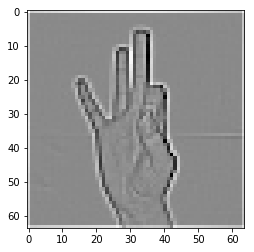

In [3]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.autograd import Variable
from tqdm import tqdm
from skimage import transform
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import os


PATH = './Dataset/'

FILE_LIST = os.listdir(PATH)

X = []
Y = []

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


for dir in FILE_LIST:
    for file in os.listdir(f"{PATH}{dir}"):
        Y.append(int(dir))
        x = transform.resize(rgb2gray(plt.imread(f"{PATH}{dir}/{file}")), (64, 64))
        X.append(x)

Y = np.array(Y)

weight =  np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
X_edge = [ndimage.convolve(x, weight, mode='constant', cval=1.0) for x in X]

X = np.array(X_edge).astype(np.float32)

plt.imshow(X[0], cmap="gray")

plt.show()

def split_train_test_data(x_data, y_data, test_size):
    indices = random.sample(range(len(x_data)), test_size)
    test_x_data = []
    for i in indices:
        test_x_data.append(x_data[i])
    test_y_data = y_data.take(indices)
    x_data = np.delete(x_data, indices, axis=0)
    y_data = np.delete(y_data, indices)
    return x_data, y_data, np.array(test_x_data), test_y_data

def transform_data(train_x, train_y, test_x, test_y):
    train_x = torch.from_numpy(train_x.reshape(-1, 1, 64, 64))
    train_y = torch.from_numpy(train_y)

    test_x = torch.from_numpy(test_x.reshape(-1, 1, 64, 64))
    test_y = torch.from_numpy(test_y)


    train_dataset = Data.TensorDataset(data_tensor=train_x, target_tensor=train_y)
    train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    test_dataset = Data.TensorDataset(data_tensor=test_x, target_tensor=test_y)
    test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    return train_loader, test_loader


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(256 * 4 * 4, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

def init_cnn():
    cnn = CNN().cuda()
    print(cnn)
    optimizer = torch.optim.ASGD(cnn.parameters(), lr = LR)
    loss_function = nn.CrossEntropyLoss()
    return cnn, optimizer, loss_function
    
def train(epoch, cnn, optimizer, loss_function, train_loader):
    total = 0
    correct = 0
    total_loss = 0
    total_step = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x).cuda()
        b_y = Variable(y).cuda()

        output = cnn(b_x)
        loss = loss_function(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        total += b_y.size(0)
        correct += predicted.eq(b_y.data).cpu().sum()
        total_loss += loss.data
        total_step = step
#         if step % 10 == 0:
#             print('Train Epoch %d | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (epoch, total_loss / (step + 1), 100.*correct/total,
#                                                                correct, total))
    return total_loss / (total_step + 1), 100.*correct/total


def test(epoch, cnn, loss_function, test_loader):
    total = 0
    correct = 0
    total_loss = 0
    total_step = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x).cuda()
        b_y = Variable(y).cuda()

        output = cnn(b_x)
        loss = loss_function(output, b_y)
        
        _, predicted = torch.max(output.data, 1)
        total += b_y.size(0)
        correct += predicted.eq(b_y.data).cpu().sum()
        total_loss += loss.data
        total_stap = step
#     print('TEST Epoch %d | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (epoch, total_loss / (total_step + 1), 100.*correct/total,
#                                                                correct, total))
    return total_loss / (total_step + 1), 100.*correct/total


def show_result(loss_train, loss_test, acc_train, acc_test):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    color = 'tab:red'
    ax[0].set_title("Loss")
    ax[0].set_xlabel('Epoch (s)')
    ax[0].set_ylabel('Train Loss', color=color)
    ax[0].plot(range(EPOCH), loss_train, color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    
    ax[1].set_title("Acc")
    ax[1].set_xlabel('Epoch (s)')
    ax[1].set_ylabel('Train Acc', color=color)
    ax[1].plot(range(EPOCH), acc_train, color=color)
    ax[1].tick_params(axis='y', labelcolor=color)
    
    
    color = 'tab:blue'
    
    ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis   
    ax1.set_ylabel('Test Loss', color=color)  # we already handled the x-label with ax1
    ax1.plot(range(EPOCH), loss_test, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis   
    ax2.set_ylabel('Test Acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(EPOCH), acc_test, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()
    
    print("Tarin Max Acc: ", max(acc_train), "%. Train Avg. Acc: ", np.average(acc_train), "%")
    print("Test Max Acc: ", max(acc_test), "%. Test Avg. Acc: ", np.average(acc_test), "%")

  0%|          | 0/10 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

Training takes:  8.117221355438232


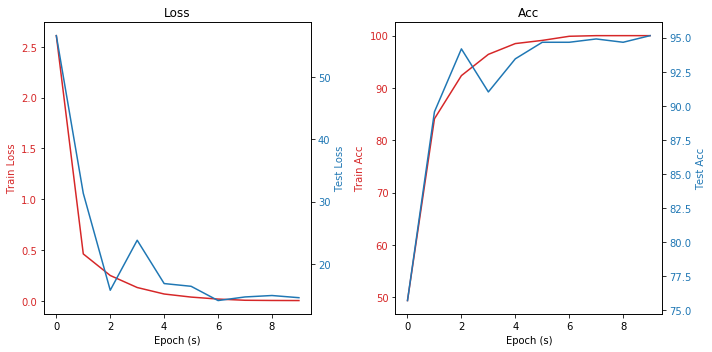

Tarin Max Acc:  100.0 %. Train Avg. Acc:  91.97575757575757 %
Test Max Acc:  95.14563106796116 %. Test Avg. Acc:  91.79611650485437 %


In [9]:
EPOCH = 10
LR = 0.001
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

In [11]:
torch.save(cnn.state_dict(), './param.pkl')

/home/alovez/.conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


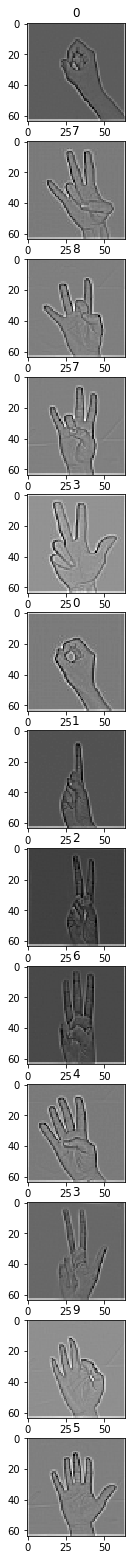

In [45]:
cnn = CNN().cuda()
cnn.load_state_dict(torch.load('./param.pkl'))

quick_test = []

for file in os.listdir("./QuickTest"):
    x = transform.resize(rgb2gray(plt.imread(f"./QuickTest/{file}")), (64, 64))
    x = ndimage.convolve(x, weight, mode='constant', cval=1.0)
    quick_test.append(x)

quick_test = np.array(quick_test).astype(np.float32)
results = []

for data in quick_test:
    test_data = torch.from_numpy(data.reshape(-1, 1, 64, 64))
    test_data = Variable(test_data).cuda()
    _, result = torch.max(cnn(test_data).data, 1)
    results.append(result)

plt.figure(figsize=(50, 30))
for i in range(len(quick_test)):
    plt.subplot(len(quick_test) + 1 ,1,i + 1)
    plt.imshow(quick_test[i], cmap='gray')
    plt.title(int(results[i]))



